In [175]:
import torch
from transformers import AutoTokenizer

import shap
import matplotlib.pyplot as plt

from error_analysis_TRC import load_local_model, prepare_data

In [176]:
ASSIGN_WEIGHT = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model_name = 'roberta-large'

model_path = '/home/cc/rora_tesi_new/log/log_TRC/roberta-large/bertweet-seq/20_epoch/data/True_weight/42_seed/saved-model/pytorch_model.bin'
config_path = '/home/cc/rora_tesi_new/log/log_TRC/roberta-large/bertweet-seq/20_epoch/data/True_weight/42_seed/saved-model/config.json'

In [177]:
train_data_path = '/home/cc/rora_tesi_new/data/train.p'
test_data_path = '/home/cc/rora_tesi_new/data/test.p'

need_columns = ['tweet','tweet_tokens', 'sentence_class']

tweet_test, tweet_tokens_test, binary_test = prepare_data(test_data_path, need_columns)




In [178]:
tokenizer = AutoTokenizer.from_pretrained(model_name, normalization = True)
model = load_local_model(model_path, config_path, device, model_name)
model = model.to(device)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
labels = sorted(model.config.label2id, key=model.config.label2id.get)
print(labels)
labels = [x.split('_')[1] for x in labels]
print(labels)

['LABEL_0', 'LABEL_1']
['0', '1']


In [48]:
torch.cuda.empty_cache()

In [179]:
# input della funzione una lista di stringhe

def f(x):
    # x = [tweet_test[0]]
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128, truncation=True) for v in x]).to(device)
    # print('tv',tv.shape)
    attention_mask = (tv!=0).type(torch.int64).to(device)
    # print('atte',attention_mask.shape)
    model.eval()
    with torch.no_grad():
        outputs = model(tv, attention_mask, class_weight=None)
    # print(outputs)

    return outputs['logits']

In [180]:
f([tweet_test[0]])

tensor([[ 2.2750, -1.6938]], device='cuda:0')

In [196]:
inputs = []
for i in range(3):
    inputs.append(tweet_test[i])

In [205]:
# explainer = shap.Explainer(f, tokenizer, output_names=labels)
explainer = shap.Explainer(f, masker = tokenizer)


In [222]:
shap_values = explainer(inputs, fixed_context='auto')

Partition explainer: 4it [00:12, 12.14s/it]               


In [224]:
shap_values[1].shape

(35, 2)

In [135]:
# shap_values = shap_values[:,:,1]
# shap_values.shape

(1, 36)

In [291]:
token_dict = {}
def create_token_dict(shap_values):
    val = [shap_values[i] for i in range(len(shap_values))]
    for el in val:
        print(len(el))
        for i in range(len(el)-1):
            token = el[i].data
            print(token)
            shap_val = el[i].values
            print(shap_val)
            # PRENDI SOLO VAL RELATIVO ALLA CLASSE POSITIVA
            


        #     print(el[2].data)
    # for i in range(len(val)):
    #     for j in range(len(val[i])):
    #         print(len(val[i]))
    #         token = val[i][j].data
    #         shap_val = val[i][j].values # o base_values(?)
 

    

In [292]:
create_token_dict(shap_values)

36

[0.00145717 0.01416494]
@
[-0.00251058  0.04691639]
USER 
[0.08877708 0.02315067]
As 
[ 0.05308496 -0.09387807]
much 
[-0.01089428 -0.0310842 ]
fun 
[-0.01816168 -0.01006266]
as 
[ 0.03734574 -0.11165352]
I 
[ 0.03692127 -0.12042355]
can
[ 0.01365735 -0.08294893]
. 
[-0.01689965  0.07898657]
W
[0.01287355 0.00164551]
oke 
[-0.10855906  0.01524628]
up 
[0.03105543 0.0053357 ]
with 
[ 0.01129034 -0.00757627]
food 
[-0.00262544  0.03018734]
poisoning 
[-0.05129     0.06250672]
or 
[-0.03354081 -0.05245386]
stomach 
[ 0.05240827 -0.06458882]
flu
[ 0.01967591 -0.05694508]
. 
[-0.11360688  0.20489133]
Been 
[ 0.18648604 -0.20418173]
bu
[ 0.14245972 -0.18317575]
gging 
[-0.0104402  -0.07844028]
me 
[ 0.01823413 -0.02772333]
all 
[ 0.03695048 -0.02621751]
day 
[0.00330932 0.05794763]
#
[-0.0702105  -0.01289343]
t
[-0.0515765  -0.03798272]
mi 
[-0.02463701  0.10290721]
Almost 
[-0.06243826  0.07629271]
done 
[-0.08070795  0.03952647]
driving 
[-0.05781013  0.11399972]
for 
[ 0.02730276 -0.0

In [272]:
[shap_values[i].values.shape for i in range(len(shap_values))]


[(36, 2), (35, 2), (32, 2)]

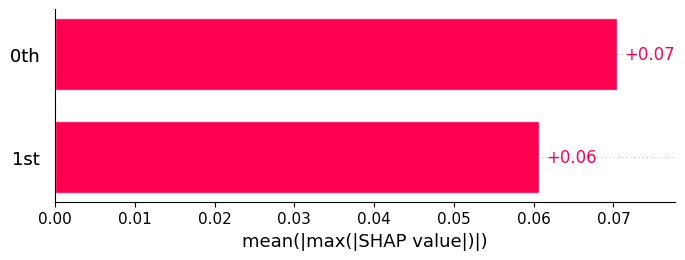

In [228]:
shap.plots.bar(shap_values.abs.max(0))

In [232]:
# per questo grafico prendi solo scores della classe positiva
# e solo gli scores di un tweet
# shap_values[:,:,1]

# input = [tweet_test[3]]
# sv = explainer(input)
# sv = sv[:,:,1]
# shap.plots.waterfall(sv[0], max_display=20)